In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
from fastai.vision import *

## Getting and converting the data

In [9]:
#! {sys.executable} -m pip install kaggle --upgrade

In [10]:
#! mkdir -p ~/.kaggle/
#! mv ~/kaggle.json ~/.kaggle/

In [11]:
path = Config.data_path()/'landmarks'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/landmarks')

In [12]:
#! kaggle datasets download jiahongqian/cephalometric-landmarks -p {path}
#! unzip -q -n {path}/cephalometric-landmarks.zip -d {path}

In [13]:
fname = 'cepha400/cepha400/001.jpg'

In [14]:
def img2txt_name(f): return str(f)[-7:]

In [15]:
img2txt_name(fname)

'001.jpg'

show image

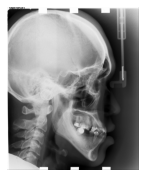

In [164]:
img = open_image(path/fname)
img.show()

show coords of points in image

In [17]:
train_df = pd.read_csv(path/'train_senior.csv')
train_df.head()

,image_path,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,...,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y
0,017.jpg,806,1028,1384,972,1258,1218,591,1212,1406,...,1530,1546,1471,2136,954,1447,1366,1504,649,1261
1,121.jpg,847,1121,1407,1118,1250,1362,601,1218,1331,...,1417,1666,1388,2245,941,1533,1383,1600,741,1441
2,033.jpg,819,1084,1457,1105,1282,1337,563,1232,1359,...,1498,1670,1467,2192,947,1530,1393,1602,604,1302
3,093.jpg,782,1003,1369,936,1236,1200,570,1178,1373,...,1487,1420,1429,2003,958,1401,1420,1371,613,1239
4,052.jpg,799,1039,1469,955,1264,1225,623,1204,1447,...,1574,1536,1644,2167,983,1445,1441,1487,662,1353


In [18]:
test1_df = pd.read_csv(path/'test1_senior.csv')
test1_df.head()

,image_path,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,...,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y
0,289.jpg,797,1034,1399,908,1298,1174,588,1245,1483,...,1579,1437,1499,1973,1009,1425,1452,1397,686,1336
1,262.jpg,794,1075,1355,1009,1225,1254,596,1261,1363,...,1499,1471,1495,1994,966,1440,1393,1428,690,1322
2,251.jpg,698,973,1302,880,1169,1160,505,1160,1375,...,1462,1412,1299,1980,888,1365,1348,1352,574,1280
3,154.jpg,839,1089,1398,1053,1289,1284,615,1211,1370,...,1477,1594,1227,2158,954,1474,1394,1551,641,1357
4,225.jpg,782,1064,1317,1039,1202,1281,569,1262,1295,...,1378,1484,1302,1946,926,1411,1306,1451,644,1301


In [19]:
test2_df = pd.read_csv(path/'test2_senior.csv')
test2_df.head()

,image_path,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,5_x,...,15_x,15_y,16_x,16_y,17_x,17_y,18_x,18_y,19_x,19_y
0,316.jpg,865,1003,1479,977,1366,1229,564,1200,1459,...,1602,1559,1505,2060,1030,1463,1493,1500,658,1339
1,381.jpg,1105,1047,1719,1023,1605,1261,919,1147,1647,...,1747,1534,1571,1979,1269,1441,1674,1495,984,1273
2,345.jpg,835,1023,1383,1045,1266,1244,575,1172,1264,...,1417,1582,1331,1981,937,1426,1325,1509,662,1277
3,383.jpg,794,1017,1376,933,1275,1178,527,1184,1320,...,1449,1460,1461,1884,949,1412,1390,1416,657,1277
4,395.jpg,858,1016,1496,965,1371,1204,620,1204,1470,...,1583,1506,1598,1912,1010,1457,1489,1496,686,1350


In [154]:
def get_ip(img,pts):
    return ImagePoints(FlowField(img.size, pts), scale=True)
def get_landmarks(f):
    img_row = train_df[train_df['image_path'] == img2txt_name(f)]
    points = []
    for i in range(19):
        point = [img_row[f'{i+1}_y'].values[0], img_row[f'{i+1}_x'].values[0]]
        points.append(point)
    return tensor(points[0])

show image with points selected

In [162]:
landmarks = get_landmarks(fname); landmarks

tensor([996, 835])

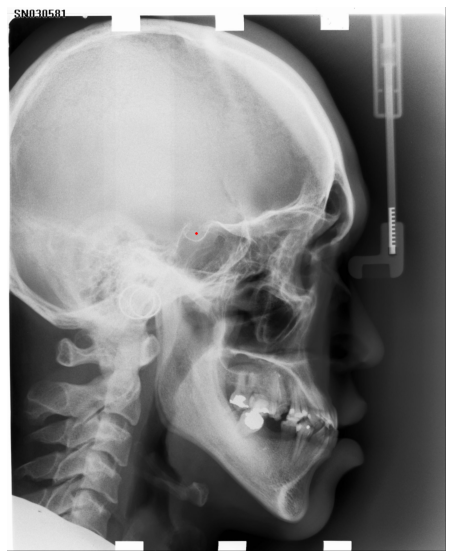

In [165]:
img.show(y=get_ip(img, landmarks), figsize=(10, 10))

## Creating a dataset

In [160]:
data = (PointsItemList.from_df(train_df, path, folder='cepha400/cepha400/')
        .split_by_rand_pct(valid_pct=0.2, seed=42)
        .label_from_func(get_landmarks)
        .transform(get_transforms(), tfm_y=True, size=(320, 258), remove_out=False)
        .databunch(bs=16)
        .normalize(imagenet_stats)
       )

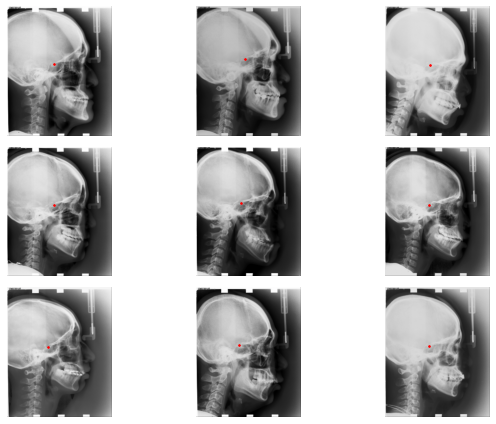

In [166]:
data.show_batch(3, ds_type=DatasetType.Valid, figsize=(9,6))

## Train model

In [167]:
# calculates distance between true and predictions
def mloss(y_true, y_pred):
    y_true=y_true.view(-1,19,2)
    
    y_true[:,:,0]=y_true[:,:,0].clone()-y_pred[:,:,0]
    y_true[:,:,1]=y_true[:,:,1].clone()-y_pred[:,:,1]
    
    y_true[:,:,0]=y_true[:,:,0].clone()**2
    y_true[:,:,1]=y_true[:,:,1].clone()**2
    
    
    return torch.mean(torch.sqrt(y_true.sum(dim=2)))

In [185]:
learn = cnn_learner(data, models.resnet34, loss_func=MSELossFlat())

epoch,train_loss,valid_loss,time
0,4.445524,#na#,00:23
1,4.332338,#na#,00:24
2,3.948612,#na#,00:23
3,3.985476,#na#,00:23
4,4.055895,#na#,00:23
5,3.889835,#na#,00:23
6,3.935088,#na#,00:24
7,3.877153,#na#,00:24
8,4.041006,#na#,00:23
9,4.199399,#na#,00:23


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


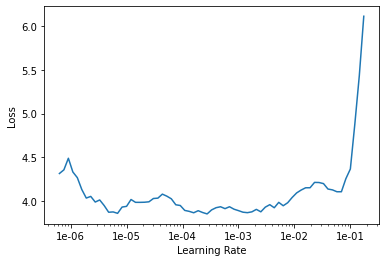

In [172]:
learn.lr_find()
learn.recorder.plot()

In [186]:
lr = 1e-03

In [187]:
learn.fit_one_cycle(50, slice(lr)) #50 in sum

epoch,train_loss,valid_loss,time
0,3.558851,2.749197,00:28
1,3.276389,1.477567,00:28
2,3.292562,1.722184,00:28
3,3.302246,1.451650,00:28
4,3.373934,1.317612,00:28
5,3.421824,1.178105,00:28
6,3.329016,1.222860,00:28
7,3.253285,1.035965,00:28
8,3.186322,0.997755,00:28
9,3.133995,0.971821,00:28


In [190]:
learn.save('stage-point0-1')

In [191]:
learn.load('stage-point0-1');

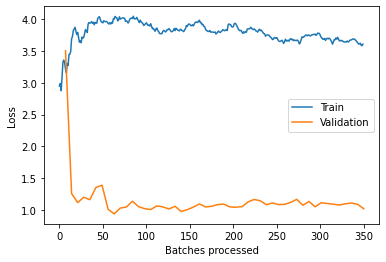

In [181]:
learn.recorder.plot_losses()

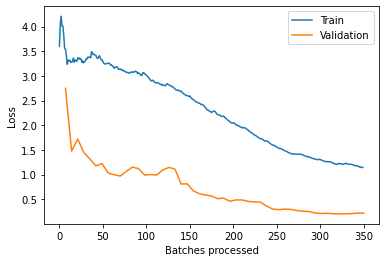

In [188]:
learn.recorder.plot_losses()

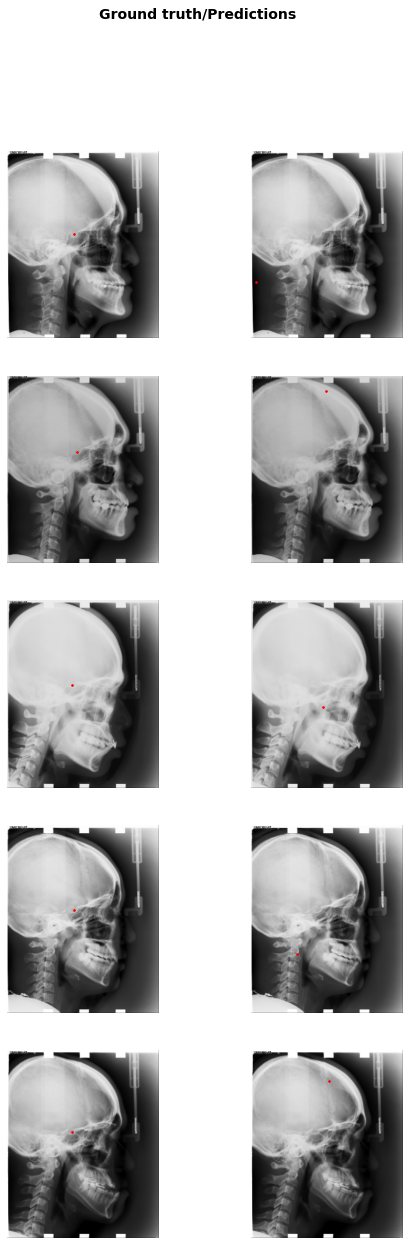

In [189]:
learn.show_results()

In [192]:
learn.unfreeze()

epoch,train_loss,valid_loss,time
0,1.026301,#na#,00:30
1,1.081896,#na#,00:30
2,1.098928,#na#,00:30
3,1.097437,#na#,00:30
4,1.108905,#na#,00:30
5,1.087202,#na#,00:30
6,1.129154,#na#,00:30
7,1.207388,#na#,00:30
8,1.144107,#na#,00:30
9,1.065851,#na#,00:30


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


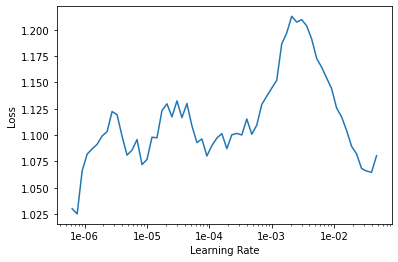

In [193]:
learn.lr_find()
learn.recorder.plot()

In [194]:
learn.fit_one_cycle(50, slice(6e-4, 1e-4)) #50 in sum

epoch,train_loss,valid_loss,time
0,1.089473,0.257967,00:36
1,1.089116,0.260501,00:37
2,1.037871,0.261299,00:37
3,1.037621,0.239337,00:37
4,1.036517,0.214105,00:37
5,1.053834,0.302765,00:37
6,1.046773,0.341363,00:38
7,1.038997,0.255212,00:37
8,1.025017,0.300552,00:37
9,1.010339,0.362199,00:37


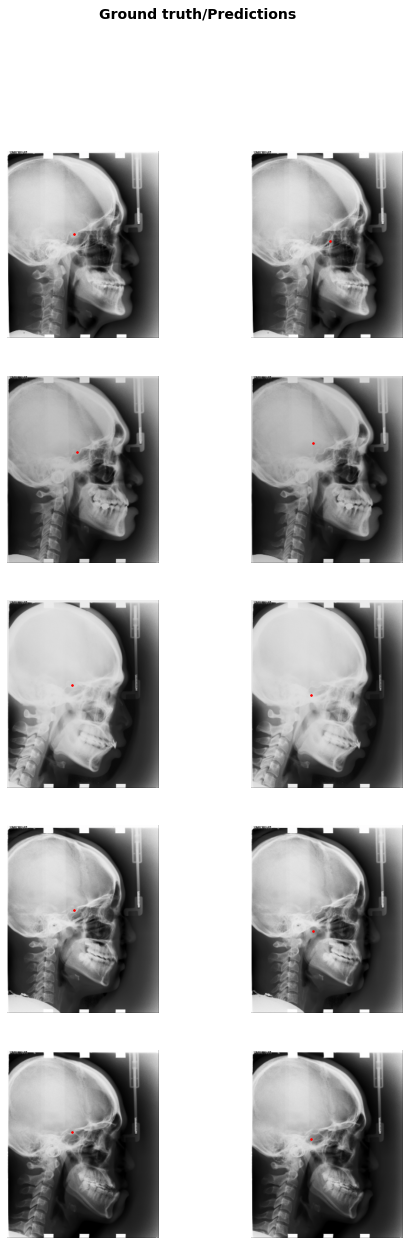

In [195]:
learn.show_results()

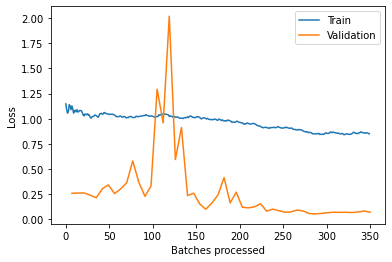

In [196]:
learn.recorder.plot_losses()

## Data augmentation

In [ ]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,6))